### B9. Morphological Dilation of Cloud mask

### 0. Load required libraries,  area dependant constants and utility functions:

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary (to have acces to the data and util catalogue)
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

from scipy import ndimage

### 1. Set up EOTasks for Dilation :

In [3]:
# defining eo_task for dilating 
from scipy import ndimage
class CloudsMaskDilation(EOTask):   
    """
    The tasks applies a static threshold to produce a data mask:
    MASK = 1 if > x else 0
    """
    def __init__(self, input_mask_name, output_mask_name, iterations, structure = ndimage.generate_binary_structure(2, 1) ):
        self.input_mask_name = input_mask_name
        self.output_mask_name = output_mask_name
        self.iterations = iterations
        self.structure =structure
        
    def execute(self, eopatch):
        cloud_masks = eopatch.mask[self.input_mask_name].squeeze()
        eo_patch_shape = cloud_masks.shape

        dilated_cloud_mask = np.copy(cloud_masks)
        for i in range(eo_patch_shape[0]):
            dilated_cloud_mask[i] = ndimage.binary_dilation(cloud_masks[i], structure =self.structure, iterations=self.iterations)

        eopatch.add_feature(FeatureType.MASK, self.output_mask_name, dilated_cloud_mask[..., np.newaxis])
        return eopatch

In [4]:
structure_1= ndimage.generate_binary_structure(2, 1)
structure_1 

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [5]:
structure_2 = ndimage.generate_binary_structure(2, 2)
structure_2

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [59]:
# creating different eo tasks  producing  dilated cloud mask as suggested in a paper

morphological_dilation_swir_100_6_str1_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_100', 'CLOUD_MASK_SWIR-1_100_dil_6_str1', 6, structure = structure_1)
morphological_dilation_swir_150_6_str1_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_150', 'CLOUD_MASK_SWIR-1_150_dil_6_str1', 6, structure = structure_1)
morphological_dilation_swir_100_6_str2_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_100', 'CLOUD_MASK_SWIR-1_100_dil_6_str2', 6, structure = structure_2)
morphological_dilation_swir_150_6_str2_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_150', 'CLOUD_MASK_SWIR-1_150_dil_6_str2', 6, structure = structure_2)

In [6]:
# creating additional eo tasks  producing  dilated cloud mask to enhence guality of cloud mask

morphological_dilation_swir_200_6_str1_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_200', 'CLOUD_MASK_SWIR-1_200_dil_6_str1', 6, structure = structure_1)
morphological_dilation_swir_300_6_str1_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_300', 'CLOUD_MASK_SWIR-1_300_dil_6_str1', 6, structure = structure_1)
morphological_dilation_swir_200_6_str2_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_200', 'CLOUD_MASK_SWIR-1_200_dil_6_str2', 6, structure = structure_2)
morphological_dilation_swir_300_6_str2_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_300', 'CLOUD_MASK_SWIR-1_300_dil_6_str2', 6, structure = structure_2)
morphological_dilation_swir_300_10_str2_eotask = CloudsMaskDilation('CLOUD_MASK_SWIR-1_300', 'CLOUD_MASK_SWIR-1_300_dil_10_str2', 10, structure = structure_2)

### 2. Set up and execute EOWorkflow

In [7]:

# application of all eotasks for all eopatches in the a eoworkflow
for date_range_landsat in site.DATE_RANGES_LANDSAT_8 :
    print('Reading EOPatches from:', date_range_landsat)
    eopatches_filepath = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[1], site.SITE_NAME, site.AVAILABLE_CRSs[0], date_range_landsat)
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(eopatches_filepath)
    save_eotask = SaveTask(eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    #morphological_dilation_swir_100_6_str1_eotask,
    #morphological_dilation_swir_150_6_str1_eotask,
    #morphological_dilation_swir_100_6_str2_eotask,
    #morphological_dilation_swir_150_6_str2_eotask,
    morphological_dilation_swir_200_6_str1_eotask, 
    morphological_dilation_swir_300_6_str1_eotask, 
    morphological_dilation_swir_200_6_str2_eotask, 
    morphological_dilation_swir_300_6_str2_eotask, 
    morphological_dilation_swir_300_10_str2_eotask,
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    execution_args = []
    for eopatch_name in list_of_available_patches:
        execution_args.append({
        load_eotask: {'eopatch_folder': eopatch_name},
        save_eotask: {'eopatch_folder': eopatch_name}
        })
    
    #print(execution_args)                            
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=1, multiprocess=False)

    executor.make_report()

Reading EOPatches from: ('2013-05-01', '2013-10-31')


C:\Users\Kamil\Anaconda3\lib\site-packages\jinja2\utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\core\data\grid.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import OrderedDict, defaultdict, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\operation\datashader.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\numba\npyufunc\dufunc.py:86: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargs

Reading EOPatches from: ('2014-05-01', '2014-10-31')



Reading EOPatches from: ('2015-05-01', '2015-10-31')



Reading EOPatches from: ('2016-05-01', '2016-10-31')



Reading EOPatches from: ('2017-05-01', '2017-10-31')



Reading EOPatches from: ('2018-05-01', '2018-10-31')



Reading EOPatches from: ('2019-05-01', '2019-10-31')


In [61]:
EO_PATCH_NAME = '2969_maxcc_0.05_x-3_y-130'

PATCH_FILEPATH = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[1], site.SITE_NAME, site.AVAILABLE_CRSs[0], site.DATE_RANGES_LANDSAT_8[0])
eo_patch = EOPatch.load(PATCH_FILEPATH+EO_PATCH_NAME)
eo_patch

EOPatch(
  data: {
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(7, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS_DAY_0: numpy.ndarray(shape=(7, 333, 333, 7), dtype=float32)
    MODIS_RAW_BANDS_DAY_AFTER: numpy.ndarray(shape=(

### 3. Check on an exemplary eopatch

2013-05-25 15:26:35
Ploting...


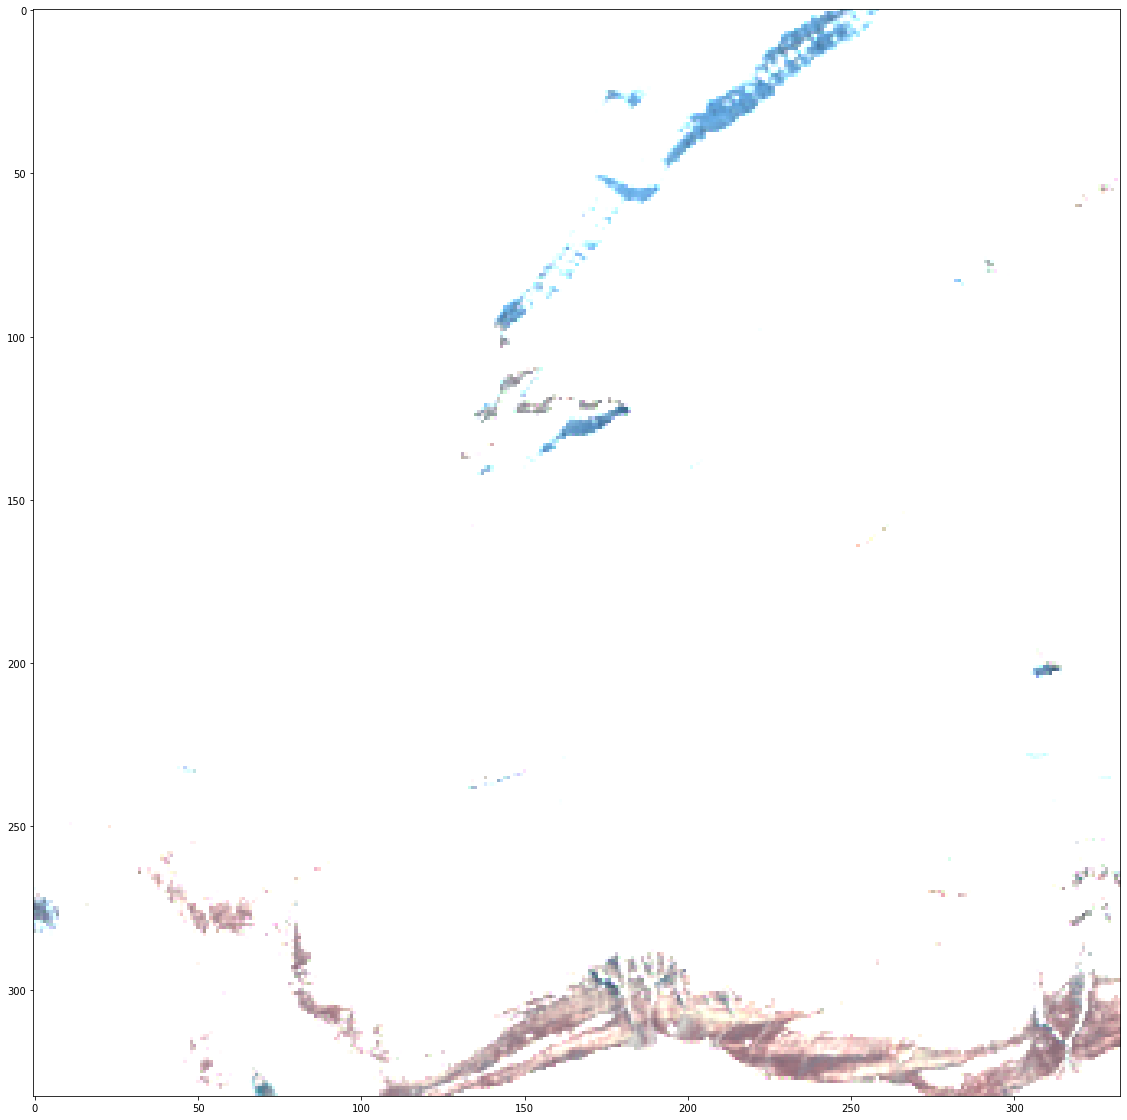

In [73]:
#plot_utils.plot_matrix(eo_patch.data['LANDSAT_RAW_BANDS'][0][...,5])
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, data_acces_name='LANDSAT_RAW_BANDS', datetime_idx=0, save=False)

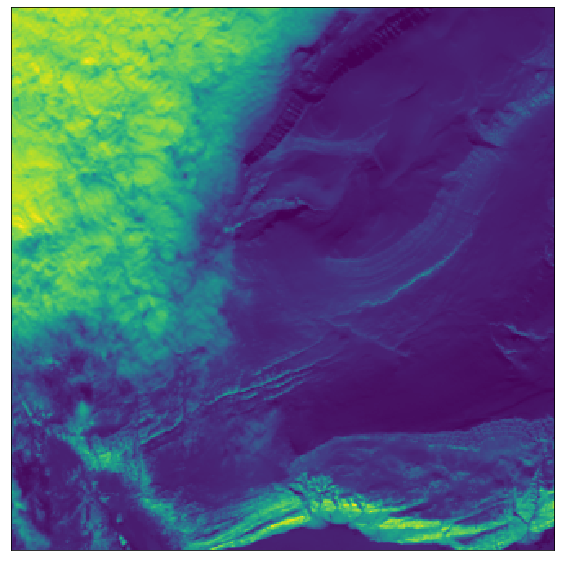

In [62]:
plot_utils.plot_matrix(eo_patch.data['LANDSAT_RAW_BANDS'][0][...,5])

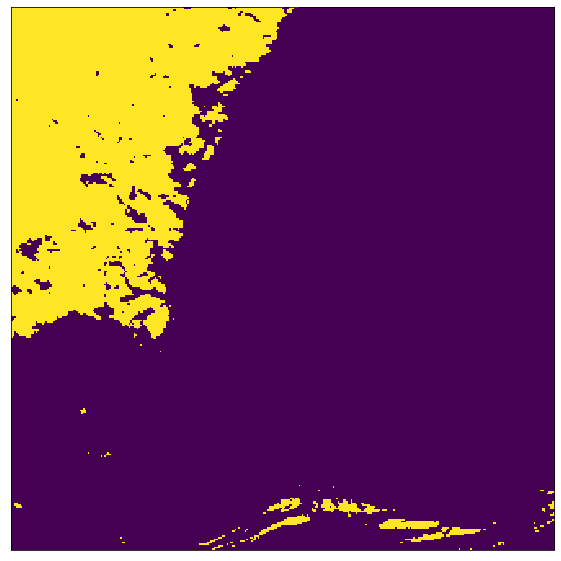

In [74]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_300'][0].squeeze())

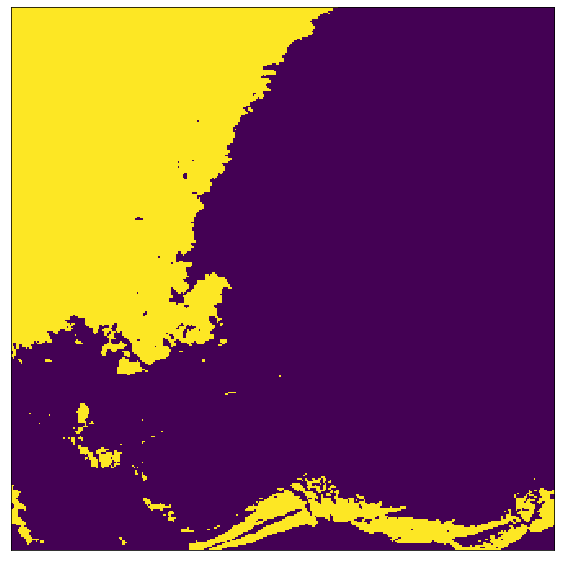

In [75]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_200'][0].squeeze())

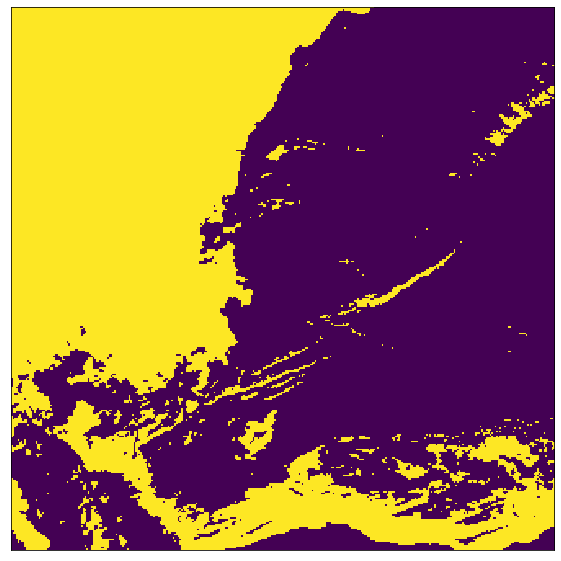

In [64]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_100'][0].squeeze())

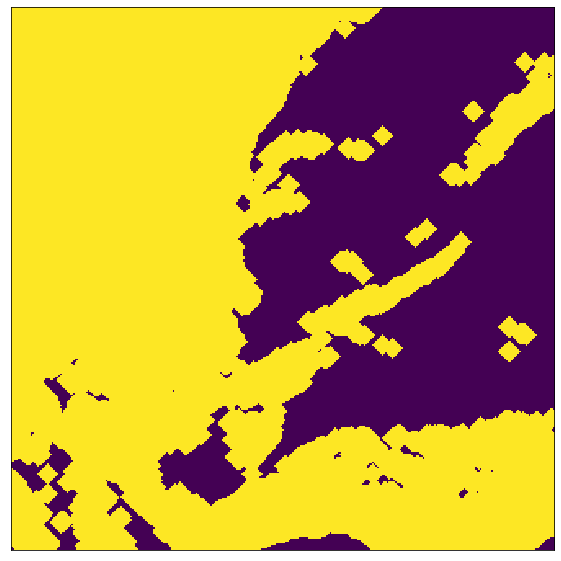

In [65]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_100_dil_6_str1'][0].squeeze())


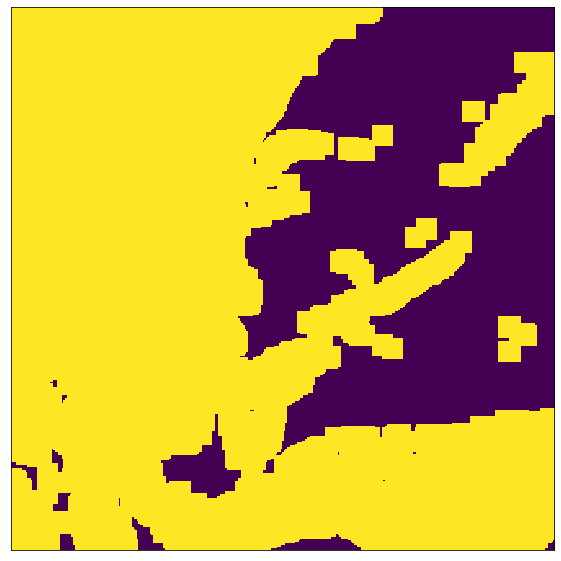

In [66]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_100_dil_6_str2'][0].squeeze())

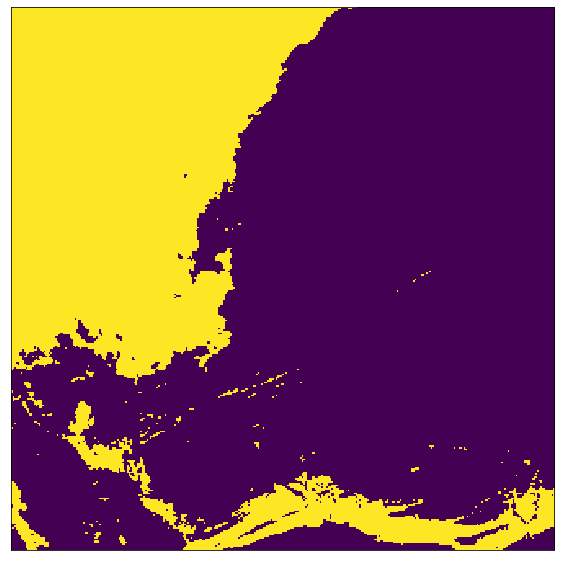

In [67]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_150'][0].squeeze())

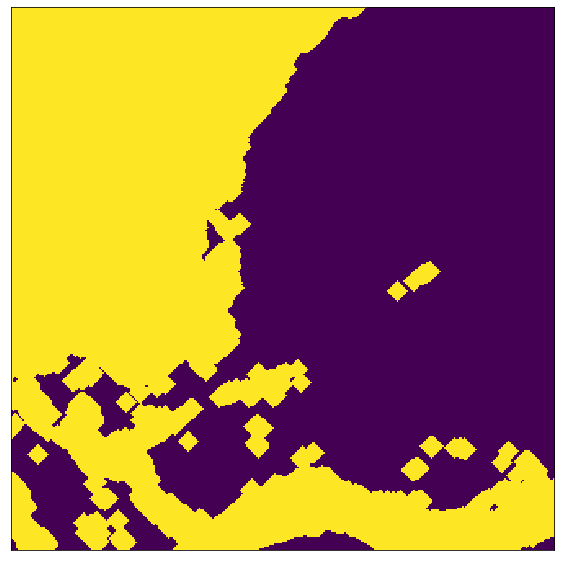

In [68]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_150_dil_6_str1'][0].squeeze())

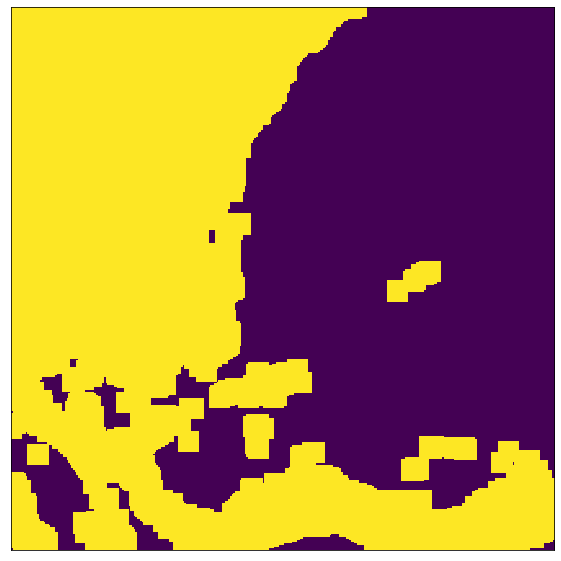

In [69]:
plot_utils.plot_matrix(eo_patch.mask['CLOUD_MASK_SWIR-1_150_dil_6_str2'][0].squeeze())

#### Sanity check:
Decited to go with the highest than suggeted in paper (suggested 100 bc TOA) 150 vs 200 with dil 6 str 2
Higher threshold does not filter out the sunny sides of the mountains and dilation should be bigger fo extract all clouds.